In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns

from keras.models import Sequential
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import fbeta_score

**File paths**

In [2]:
path = "../input/planets-dataset/"
os.listdir(path)

['planet', 'test-jpg-additional']

In [3]:
path = "../input/planets-dataset/planet/planet"
os.listdir(path)

['sample_submission.csv', 'test-jpg', 'train_classes.csv', 'train-jpg']

In [4]:
# File Paths
train_csv_path = "../input/planets-dataset/planet/planet/train_classes.csv"
train_images_path = "../input/planets-dataset/planet/planet/train-jpg/"
sample_submission_csv_path = "../input/planets-dataset/planet/planet/sample_submission.csv"
test_images_path = "../input/planets-dataset/planet/planet/test-jpg/"

**Loading the data**

In [5]:
train_df = pd.read_csv(train_csv_path)
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
submission_df = pd.read_csv(sample_submission_csv_path)
submission_df .head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


**Data Understanding**

In [7]:
train_images = [image for image in os.listdir(train_images_path) if image.endswith('.jpg')]
train_images[:10]

['train_30370.jpg',
 'train_11814.jpg',
 'train_14358.jpg',
 'train_18588.jpg',
 'train_36435.jpg',
 'train_20663.jpg',
 'train_27590.jpg',
 'train_34219.jpg',
 'train_35721.jpg',
 'train_32767.jpg']

In [8]:
# Print the number of images in train_images
len(train_images)

40479

In [9]:
# Checking if the number of images in the 'train_classes.csv' file is the same in the 'train_jpg' file
len(train_df) == len(train_images)

True

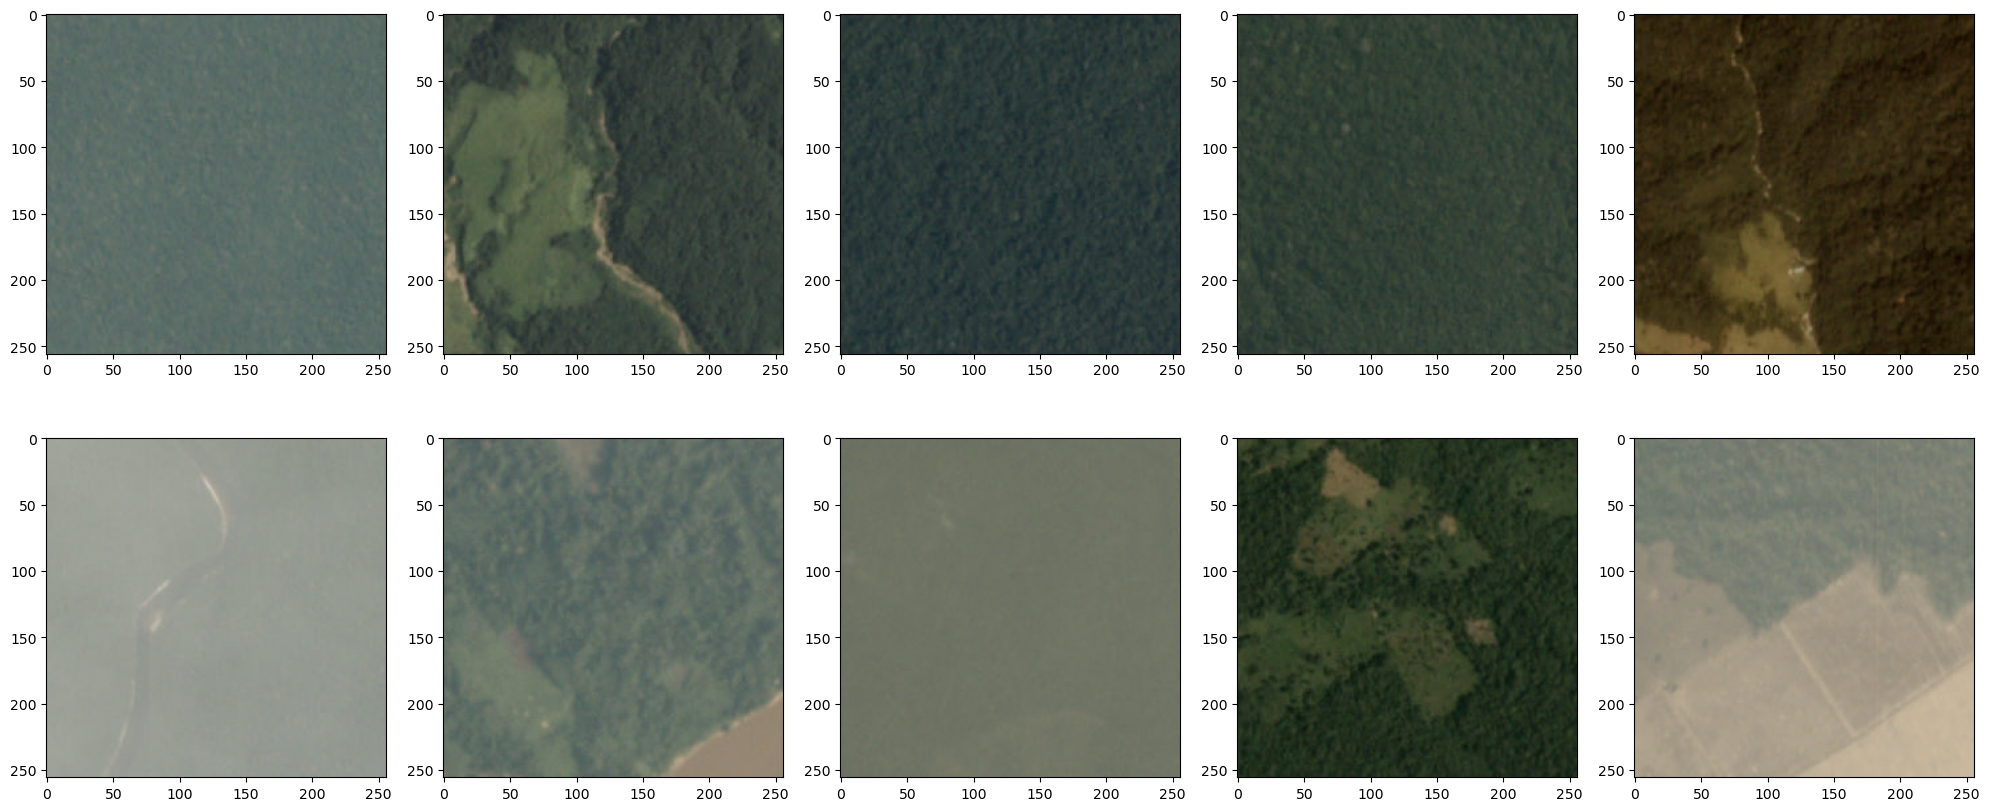

In [10]:
# Viewing first 10 images

train_img_filepath = train_images_path

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,10))
fig.set_tight_layout(True)

for i in range(10):
    ax = axes[i//5][i%5] 
    image = mpimg.imread(train_img_filepath + 'train_' + str(i) + '.jpg')
    ax.imshow(image)

In [11]:
# Viewing the tags_df column

train_df['tags'].value_counts()

# There is more than one tag for each observation separated by a space

clear primary                                               13636
partly_cloudy primary                                        3630
cloudy                                                       2089
clear primary water                                          1850
agriculture clear primary road                               1680
                                                            ...  
agriculture clear cultivation cultivation road                  1
artisinal_mine bare_ground partly_cloudy primary road           1
agriculture clear conventional_mine primary road                1
clear conventional_mine habitation road                         1
agriculture partly_cloudy primary road conventional_mine        1
Name: tags, Length: 449, dtype: int64

In [12]:
# Splitting the tags into a list of strings
tags_lists = train_df['tags'].map(lambda x: x.split(' '))
tags_list = [tag for list in tags_lists.values for tag in list]
tags_list[:10]

['haze',
 'primary',
 'agriculture',
 'clear',
 'primary',
 'water',
 'clear',
 'primary',
 'clear',
 'primary']

In [13]:
# Number of unique tags
tags = []
for tag in tags_list:
    if tag not in tags:
        tags.append(tag)
    else:
        pass
len(tags)

17

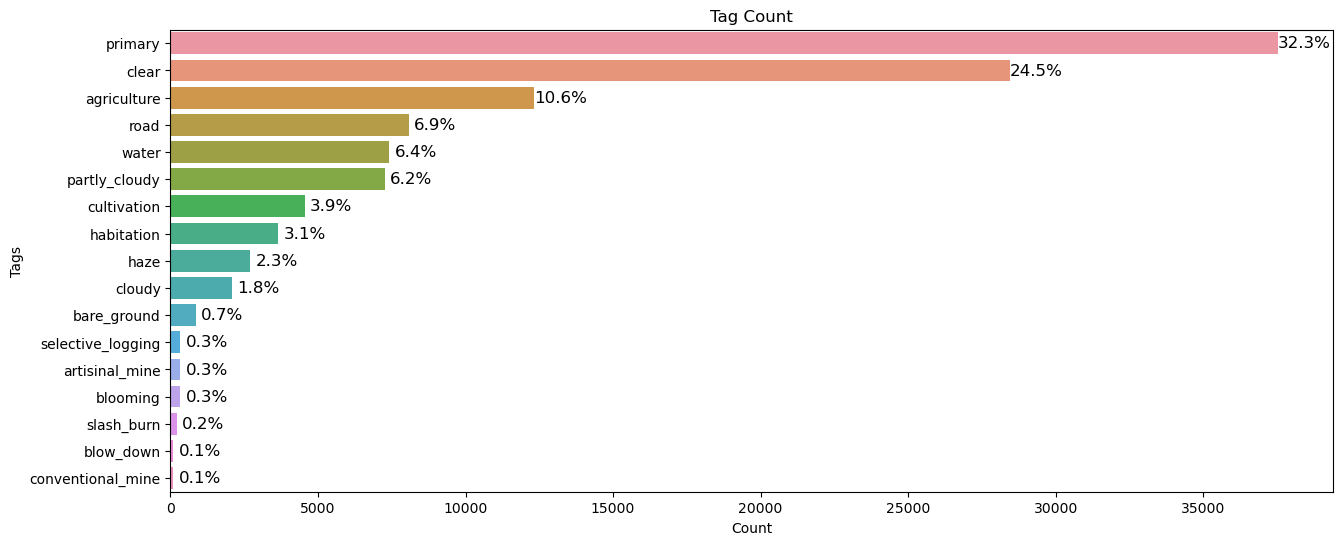

In [14]:
# Plotting the tag count

tag_count = pd.Series(tags_list).value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x=tag_count.values, y=tag_count.index, ax=ax)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Count')
ax.set_ylabel('Tags')
ax.set_title('Tag Count')

for i, value in enumerate(tag_count.values):
    ax.annotate(f'{value/sum(tag_count.values)*100:.1f}%', 
                xy=(value, i), 
                xytext=(19,0),
                textcoords='offset points', 
                ha='center',
                va='center',
                fontsize=12)

**Data Preparation**

In [15]:
# Perform ohe encoding
for tag in tags:
    train_df[tag] = train_df['tags'].map(lambda x: 1 if tag in x else 0)
train_df.tail()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
40474,train_40474,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
40475,train_40475,cloudy,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
40476,train_40476,agriculture clear primary,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
40477,train_40477,agriculture clear primary road,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
40478,train_40478,agriculture cultivation partly_cloudy primary,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0


In [16]:
# Adding .jpg to the image_names

train_df['image_name'] = train_df['image_name'].map(lambda x: x+'.jpg')
train_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0.jpg,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [17]:
# Length of the test dataset
len([image for image in os.listdir(test_images_path)])

40669

In [18]:
# Creating the test df
test_df = submission_df[['image_name']].copy()
test_df['image_name'] = test_df['image_name'].map(lambda x: x+'.jpg')
test_df = test_df.iloc[:40669].copy()
test_df

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg
...,...
40664,test_40664.jpg
40665,test_40665.jpg
40666,test_40666.jpg
40667,test_40667.jpg


### **Image Preprocessing**

In [19]:
train_datagen = ImageDataGenerator(
                                rescale=1./255.0,
                                validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255.0)

In [20]:
train_generator = train_datagen.flow_from_dataframe(
                dataframe=train_df,
                directory = train_images_path, 
                x_col = 'image_name',
                y_col = tags,
                subset='training',
                batch_size=16,
                seed=42,
                shuffle=True,
                class_mode='raw',
                target_size=(128,128))


validation_generator = train_datagen.flow_from_dataframe(
                dataframe=train_df,
                directory = train_images_path, 
                x_col = 'image_name',
                y_col = tags,
                subset='validation',
                batch_size=16,
                seed=42,
                shuffle=True,
                class_mode='raw',
                target_size=(128,128)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_images_path,
    x_col='image_name',
    y_col=None,
    batch_size=16,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(128,128)
)


Found 32384 validated image filenames.
Found 8095 validated image filenames.
Found 40669 validated image filenames.


**Modelling**

In [21]:
def fbeta(y_true, y_pred, beta = 2, epsilon = 1e-4):
    '''
    Computes the fbeta score given the true and predicted labels.

    Args:
        y_true: The true labels.
        y_pred: The predicted labels.
        beta: The beta value for fbeta score. Default value is 2.0.
        epsilon: A small value to avoid dividing by zero. Default value is 1e-7.

    Returns:
        The fbeta score.
    '''
    
    beta_squared = beta**2
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
     
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision+recall+epsilon)
    return fb

In [22]:
def multi_label_acc(y_true, y_pred, epsilon = 1e-4):
    '''
        Retuns accuracy value for multi_label classification

    Args:
        y_true: correct target values
        y_pred: predicted values returned by the classifier
        epsilon: small constant to avoid division by zero

    '''
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
        
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32)
                       * tf.cast(tf.logical_not(y_pred), tf.float32), axis = 1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [23]:
# Model with different layers

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256,(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(17, activation='sigmoid'))

In [24]:
#Compiling the model

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=1e-4),
              metrics=[multi_label_acc, fbeta])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                    

In [25]:
save_best_check_point = ModelCheckpoint(filepath = 'best_model.hdf5', 
                                        monitor = 'val_fbeta',
                                        mode = 'max',
                                        save_best_only = True,
                                        save_weights_only = True)

In [26]:
# Fitting the model
history = model.fit(x=train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size, 
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    epochs=10)

Epoch 1/10
2024/2024 [==============================] - 136s 66ms/step - loss: 0.2230 - multi_label_acc: 0.9131 - fbeta: 0.7097 - val_loss: 0.1666 - val_multi_label_acc: 0.9343 - val_fbeta: 0.8029
Epoch 2/10
2024/2024 [==============================] - 132s 65ms/step - loss: 0.1574 - multi_label_acc: 0.9377 - fbeta: 0.8095 - val_loss: 0.1430 - val_multi_label_acc: 0.9442 - val_fbeta: 0.8283
Epoch 3/10
2024/2024 [==============================] - 132s 65ms/step - loss: 0.1428 - multi_label_acc: 0.9432 - fbeta: 0.8292 - val_loss: 0.1366 - val_multi_label_acc: 0.9458 - val_fbeta: 0.8351
Epoch 4/10
2024/2024 [==============================] - 113s 56ms/step - loss: 0.1347 - multi_label_acc: 0.9460 - fbeta: 0.8385 - val_loss: 0.1321 - val_multi_label_acc: 0.9473 - val_fbeta: 0.8425
Epoch 5/10
2024/2024 [==============================] - 113s 56ms/step - loss: 0.1266 - multi_label_acc: 0.9491 - fbeta: 0.8509 - val_loss: 0.1269 - val_multi_label_acc: 0.9491 - val_fbeta: 0.8609
Epoch 6/10
2024

**The model is performing fairly well there seems to be little overfitting**

## **Prediction on test data**

In [27]:
test_generator.reset()
preds = model.predict(test_generator, steps = test_generator.samples // test_generator.batch_size, verbose = 1)
preds

2541/2541 [==============================] - 137s 54ms/step


array([[3.3211694e-04, 9.9999034e-01, 4.2411825e-03, ..., 4.6850634e-03,
        2.8205960e-04, 1.7546593e-04],
       [5.0904098e-05, 9.9999201e-01, 6.1526336e-03, ..., 2.4453017e-03,
        1.0490088e-03, 1.5905080e-03],
       [5.5014484e-06, 9.9986970e-01, 2.9154213e-03, ..., 6.2279445e-11,
        1.1999396e-07, 8.8893310e-09],
       ...,
       [3.7871645e-04, 9.9993396e-01, 3.3286642e-03, ..., 8.6922199e-04,
        1.0186852e-04, 5.2961725e-05],
       [3.7069019e-04, 9.9901247e-01, 4.9657372e-01, ..., 9.7779473e-09,
        2.6327019e-04, 3.2216152e-09],
       [1.2829364e-04, 9.9998164e-01, 2.9930011e-03, ..., 3.6904875e-03,
        3.9458935e-04, 1.9007067e-04]], dtype=float32)

In [30]:
predictions = pd.DataFrame(preds)
test_df['tags'] = predictions.apply(lambda x: ' '.join(np.array(tags)[x > 0.5]), axis = 1)

test_df.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary cloudy partly_cloudy
3,test_3.jpg,primary agriculture clear cultivation
4,test_4.jpg,cloudy


In [31]:
test_df['image_name'] = test_df['image_name'].map(lambda x: x[:-4])
test_df.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary cloudy partly_cloudy
3,test_3,primary agriculture clear cultivation
4,test_4,cloudy


**Prediction on added test dataframe**

In [54]:
submission_df = pd.read_csv(sample_submission_csv_path)

In [85]:
added_test_df = submission_df.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
added_test_df['image_name'] = added_test_df['image_name'].map(lambda x: x+'.jpg')
added_test_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [66]:
added_df_path = "/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/"

In [68]:
# additional images generator 
add_test_generator = test_datagen.flow_from_dataframe(dataframe = added_test_df, 
                                                    directory = added_df_path,
                                                    x_col='image_name', 
                                                    y_col=None, 
                                                    batch_size=16, 
                                                    shuffle=False, 
                                                    class_mode=None, 
                                                    target_size=(128,128)
                                                     )

Found 20522 validated image filenames.


In [69]:
# Prediction

add_test_generator.reset()
preds = model.predict(add_test_generator, steps = add_test_generator.samples // add_test_generator.batch_size, verbose = 1)


1282/1282 [==============================] - 135s 105ms/step


In [86]:
# Converting preds into dataframe
additional_preds = pd.DataFrame(preds)
# Getting the tags
added_test_df['tags'] = additional_preds.apply(lambda x: ' '.join(np.array(tags)[x>0.5]), axis = 1)
added_test_df['image_name'] = added_test_df['image_name'].map(lambda x: x[:-4])
added_test_df.head()

,image_name,tags
0,file_0,primary clear
1,file_1,primary agriculture cloudy partly_cloudy
2,file_10,primary water road
3,file_100,primary clear
4,file_1000,primary clear


In [87]:
complete_submission_df = pd.concat([test_df, added_test_df])
complete_submission_df.shape

(61191, 2)

**Saving the results as a csv file and Creating a download link**

In [88]:
from IPython.display import HTML
import pandas as pd
import numpy as np

complete_submission_df.to_csv('submission.csv', index = False)

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submission.csv')

**Submission Score**

<img src="submission_result.jpg" alt="Submission Score screenshot">